## 手写数字识别

In [1]:
# 此段数据读取代码无需掌握
import gzip
import numpy as np

file_path = "D:\\file\\vscode\\data\\MNIST\\"

def read_mnist(images_path, labels_path):
    with gzip.open(file_path + labels_path, "rb") as labelsFile:
        y = np.frombuffer(labelsFile.read(), dtype=np.uint8, offset=8)

    with gzip.open(file_path + images_path, "rb") as imagesFile:
        X = (
            np.frombuffer(imagesFile.read(), dtype=np.uint8, offset=16)
            .reshape(len(y), 784)
            .reshape(len(y), 28, 28, 1)
        )

    return X, y


train = {}
test = {}

train["X"], train["y"] = read_mnist(
    "train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz"
)
test["X"], test["y"] = read_mnist(
    "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"
)

train["X"].shape, train["y"].shape, test["X"].shape, test["y"].shape

((60000, 28, 28, 1), (60000,), (10000, 28, 28, 1), (10000,))

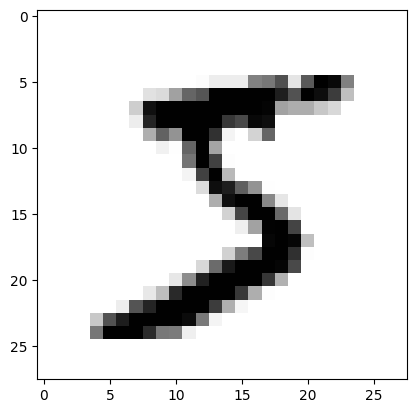

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.imshow(train["X"][0].reshape(28, 28), cmap=plt.cm.gray_r)

In [3]:
# 样本 padding 填充
X_train = np.pad(train["X"], ((0, 0), (2, 2), (2, 2), (0, 0)), "constant")
X_test = np.pad(test["X"], ((0, 0), (2, 2), (2, 2), (0, 0)), "constant")
# 标签独热编码
y_train = np.eye(10)[train["y"].reshape(-1)]
y_test = np.eye(10)[test["y"].reshape(-1)]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 32, 32, 1), (10000, 32, 32, 1), (60000, 10), (10000, 10))

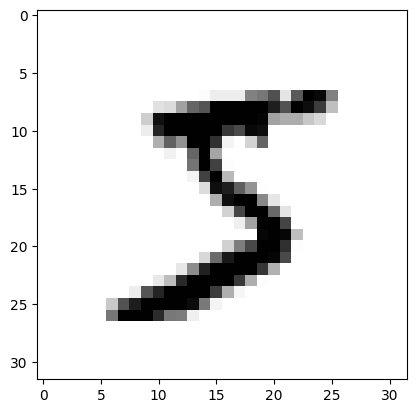

In [4]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.imshow(X_train[0].reshape(32, 32), cmap=plt.cm.gray_r)

## tensorflow 构建

In [5]:
import tensorflow as tf

model = tf.keras.Sequential()  # 构建顺序模型

# 卷积层，6 个 5x5 卷积核，步长为 1，relu 激活，第一层需指定 input_shape
model.add(
    tf.keras.layers.Conv2D(
        filters=6,
        kernel_size=(5, 5),
        strides=(1, 1),
        activation="relu",
        input_shape=(32, 32, 1),
    )
)
# 平均池化，池化窗口默认为 2
model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2))
# 卷积层，16 个 5x5 卷积核，步为 1，relu 激活
model.add(
    tf.keras.layers.Conv2D(
        filters=16, kernel_size=(5, 5), strides=(1, 1), activation="relu"
    )
)
# 平均池化，池化窗口默认为 2
model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2))
# 需展平后才能与全连接层相连
model.add(tf.keras.layers.Flatten())
# 全连接层，输出为 120，relu 激活
model.add(tf.keras.layers.Dense(units=120, activation="relu"))
# 全连接层，输出为 84，relu 激活
model.add(tf.keras.layers.Dense(units=84, activation="relu"))
# 全连接层，输出为 10，Softmax 激活
model.add(tf.keras.layers.Dense(units=10, activation="softmax"))
# 查看网络结构
model.summary()

d:\file\env\conda\envs\network\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# 编译模型，Adam 优化器，多分类交叉熵损失函数，准确度评估
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [7]:
# 模型训练及评估
model.fit(X_train, y_train, batch_size=64, epochs=2, validation_data=(X_test, y_test))

Epoch 1/2
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8515 - loss: 0.9716 - val_accuracy: 0.9770 - val_loss: 0.0740
Epoch 2/2
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9785 - loss: 0.0698 - val_accuracy: 0.9832 - val_loss: 0.0536


## pytorch 实现

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 卷积层 1
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=(5, 5), stride=1
        )
        # 池化层 1
        self.pool1 = nn.AvgPool2d(kernel_size=(2, 2))
        # 卷积层 2
        self.conv2 = nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=(5, 5), stride=1
        )
        # 池化层 2
        self.pool2 = nn.AvgPool2d(kernel_size=(2, 2))
        # 全连接层
        self.fc1 = nn.Linear(in_features=5 * 5 * 16, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.reshape(-1, 5 * 5 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

In [20]:
model = LeNet()
model

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [21]:
model(torch.Tensor(X_train[0]).reshape(-1, 1, 32, 32))

tensor([[9.2978e-05, 1.7123e-02, 8.6989e-02, 7.0102e-04, 3.4180e-04, 8.6692e-01,
         2.9725e-03, 1.2741e-02, 7.6293e-03, 4.4861e-03]],
       grad_fn=<SoftmaxBackward0>)

In [22]:
import torch.utils.data

# 依次传入样本和标签张量，制作训练数据集和测试数据集
train_data = torch.utils.data.TensorDataset(
    torch.Tensor(X_train), torch.Tensor(train["y"])
)
test_data = torch.utils.data.TensorDataset(
    torch.Tensor(X_test), torch.Tensor(test["y"])
)

train_data, test_data

(<torch.utils.data.dataset.TensorDataset at 0x1e48b867bc0>,
 <torch.utils.data.dataset.TensorDataset at 0x1e416f47ec0>)

In [23]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x1e48c23f9e0>,
 <torch.utils.data.dataloader.DataLoader at 0x1e416e390a0>)

In [24]:
loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数
opt = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam 优化器

In [25]:
def fit(epochs, model, opt):
    # 全数据集迭代 epochs 次
    print("================ Start Training =================")
    for epoch in range(epochs):
        # 从数据加载器中读取 Batch 数据开始训练
        for i, (images, labels) in enumerate(train_loader):
            images = images.reshape(-1, 1, 32, 32)  # 对特征数据展平，变成 784
            labels = labels.type(torch.LongTensor)  # 真实标签

            outputs = model(images)  # 前向传播
            loss = loss_fn(outputs, labels)  # 传入模型输出和真实标签

            opt.zero_grad()  # 优化器梯度清零，否则会累计
            loss.backward()  # 从最后 loss 开始反向传播
            opt.step()  # 优化器迭代

            # 自定义训练输出样式
            if (i + 1) % 100 == 0:
                print(
                    "Epoch [{}/{}], Batch [{}/{}], Train loss: [{:.3f}]".format(
                        epoch + 1, epochs, i + 1, len(train_loader), loss.item()
                    )
                )

        # 每个 Epoch 执行一次测试
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.reshape(-1, 1, 32, 32)
            labels = labels.type(torch.LongTensor)

            outputs = model(images)
            # 得到输出最大值 _ 及其索引 predicted
            _, predicted = torch.max(outputs.data, 1)

            correct += (predicted == labels).sum().item()  # 如果预测结果和真实值相等则计数 +1
            total += labels.size(0)  # 总测试样本数据计数

        print(
            "============= Test accuracy: {:.3f} ==============".format(correct / total)
        )

In [26]:
fit(epochs=2, model=model, opt=opt)

================ Start Training =================
Epoch [1/2], Batch [100/938], Train loss: [1.766]
Epoch [1/2], Batch [200/938], Train loss: [1.627]
Epoch [1/2], Batch [300/938], Train loss: [1.604]
Epoch [1/2], Batch [400/938], Train loss: [1.657]
Epoch [1/2], Batch [500/938], Train loss: [1.641]
Epoch [1/2], Batch [600/938], Train loss: [1.601]
Epoch [1/2], Batch [700/938], Train loss: [1.608]
Epoch [1/2], Batch [800/938], Train loss: [1.497]
Epoch [1/2], Batch [900/938], Train loss: [1.506]
============= Test accuracy: 0.961 ==============
Epoch [2/2], Batch [100/938], Train loss: [1.488]
Epoch [2/2], Batch [200/938], Train loss: [1.481]
Epoch [2/2], Batch [300/938], Train loss: [1.477]
Epoch [2/2], Batch [400/938], Train loss: [1.490]
Epoch [2/2], Batch [500/938], Train loss: [1.478]
Epoch [2/2], Batch [600/938], Train loss: [1.477]
Epoch [2/2], Batch [700/938], Train loss: [1.494]
Epoch [2/2], Batch [800/938], Train loss: [1.477]
Epoch [2/2], Batch [900/938], Train loss: [1.492]


In [27]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.reshape(input.size(0), -1)


# 构建 Sequential 容器结构
model_s = nn.Sequential(
    nn.Conv2d(1, 6, (5, 5), 1),
    nn.ReLU(),
    nn.AvgPool2d((2, 2)),
    nn.Conv2d(6, 16, (5, 5), 1),
    nn.ReLU(),
    nn.AvgPool2d((2, 2)),
    Flatten(),
    nn.Linear(5 * 5 * 16, 120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 10),
    nn.Softmax(dim=1),
)

model_s

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (6): Flatten()
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
  (12): Softmax(dim=1)
)

In [28]:
opt_s = torch.optim.Adam(model_s.parameters(), lr=0.001)  # Adam 优化器
fit(epochs=2, model=model_s, opt=opt_s)

================ Start Training =================
Epoch [1/2], Batch [100/938], Train loss: [1.559]
Epoch [1/2], Batch [200/938], Train loss: [1.655]
Epoch [1/2], Batch [300/938], Train loss: [1.638]
Epoch [1/2], Batch [400/938], Train loss: [1.572]
Epoch [1/2], Batch [500/938], Train loss: [1.544]
Epoch [1/2], Batch [600/938], Train loss: [1.520]
Epoch [1/2], Batch [700/938], Train loss: [1.509]
Epoch [1/2], Batch [800/938], Train loss: [1.500]
Epoch [1/2], Batch [900/938], Train loss: [1.514]
============= Test accuracy: 0.969 ==============
Epoch [2/2], Batch [100/938], Train loss: [1.476]
Epoch [2/2], Batch [200/938], Train loss: [1.492]
Epoch [2/2], Batch [300/938], Train loss: [1.483]
Epoch [2/2], Batch [400/938], Train loss: [1.510]
Epoch [2/2], Batch [500/938], Train loss: [1.477]
Epoch [2/2], Batch [600/938], Train loss: [1.486]
Epoch [2/2], Batch [700/938], Train loss: [1.477]
Epoch [2/2], Batch [800/938], Train loss: [1.492]
Epoch [2/2], Batch [900/938], Train loss: [1.478]
